## Intro

Задача проекта - предсказание температуры стали на выходе этапа обработки на производстве.

Описание процесса обработки:

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sn
from lightgbm import LGBMRegressor
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

In [196]:
slash = ''
if not os.path.exists('datasets/data_arc_new.csv'):
    slash='/'

In [197]:
dateparse = lambda dates: [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dates]

data_arc_new = pd.read_csv(slash + 'datasets/data_arc_new.csv', parse_dates=['Начало нагрева дугой','Конец нагрева дугой'], date_format='%Y-%m-%d %H:%M:%S', index_col='key')
data_bulk_new = pd.read_csv(slash + 'datasets/data_bulk_new.csv', date_format='%Y-%m-%d %H:%M:%S', index_col='key')
data_bulk_time_new = pd.read_csv(slash + 'datasets/data_bulk_time_new.csv', parse_dates=True, date_format='%Y-%m-%d %H:%M:%S', index_col='key')
data_gas_new = pd.read_csv(slash + 'datasets/data_gas_new.csv', index_col='key')
data_temp_new = pd.read_csv(slash + 'datasets/data_temp_new.csv', parse_dates=['Время замера'], date_format='%Y-%m-%d %H:%M:%S', index_col='key')
data_wire_new = pd.read_csv(slash + 'datasets/data_wire_new.csv', index_col='key')
data_wire_time_new = pd.read_csv(slash + 'datasets/data_wire_time_new.csv', parse_dates=True, date_format='%Y-%m-%d %H:%M:%S', index_col='key')

## Overview

In [198]:
def data_info(data):
    print(data.head())
    print(data.info())
    print(data.describe())

def data_graphics(data, bins=100, title='Data', xlabel='value', ylabel='count', datetime=False, one_graph=False, rotation=0):
    
    cols_count = len(data.columns)
    
    if cols_count == 1:
        data.hist(bins=bins)
        plt.title(title + ' distribution')
        plt.grid(True)
        plt.xlabel(xlabel)
        plt.xticks(rotation = rotation)
        plt.ylabel(ylabel)
        
    else:
        fig, axs = plt.subplots(cols_count, figsize=(9, 5 * cols_count))
        fig.suptitle(title + ' distribution')
        fig.tight_layout(pad=8.0)
    
        ax_n = 0
        for column in data.columns:
            axs[ax_n].hist(data[column], bins=bins)
            axs[ax_n].title.set_text(column + ' distribution')
            axs[ax_n].grid(True)
            axs[ax_n].set_xlabel(xlabel)
            axs[ax_n].set_ylabel(ylabel)
            axs[ax_n].tick_params('x', labelrotation=rotation)
            ax_n+=1
    
    if not datetime:
        data.plot(kind='box', figsize=(8, 10), grid=True)
        plt.title(title + ' boxplot')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
        
def data_nan_count(data):
    print(data.isna().sum()/data.shape[0])

#### Arc

In [199]:
data_info(data_arc_new)

    Начало нагрева дугой Конец нагрева дугой  Активная мощность   
key                                                               
1    2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130  \
1    2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
1    2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
1    2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
1    2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   

     Реактивная мощность  
key                       
1               0.211253  
1               0.477438  
1               0.430460  
1               0.379979  
1               0.643691  
<class 'pandas.core.frame.DataFrame'>
Index: 14876 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Начало нагрева дугой  14876 non-null  datetime64[ns]
 1   Конец нагрева дугой   14876 non-null  datetime64[ns]
 2   Ак

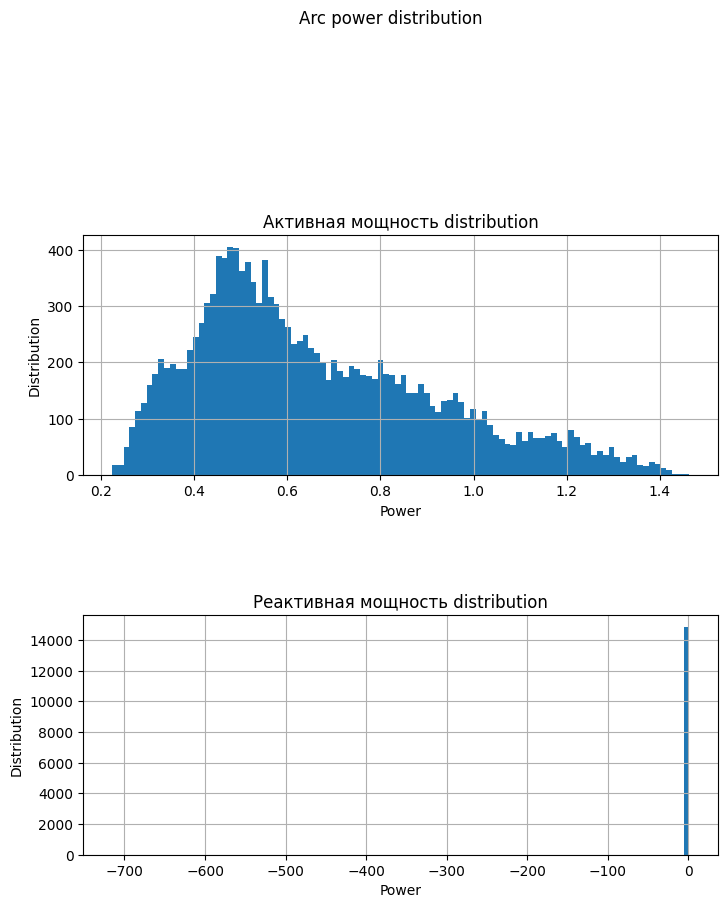

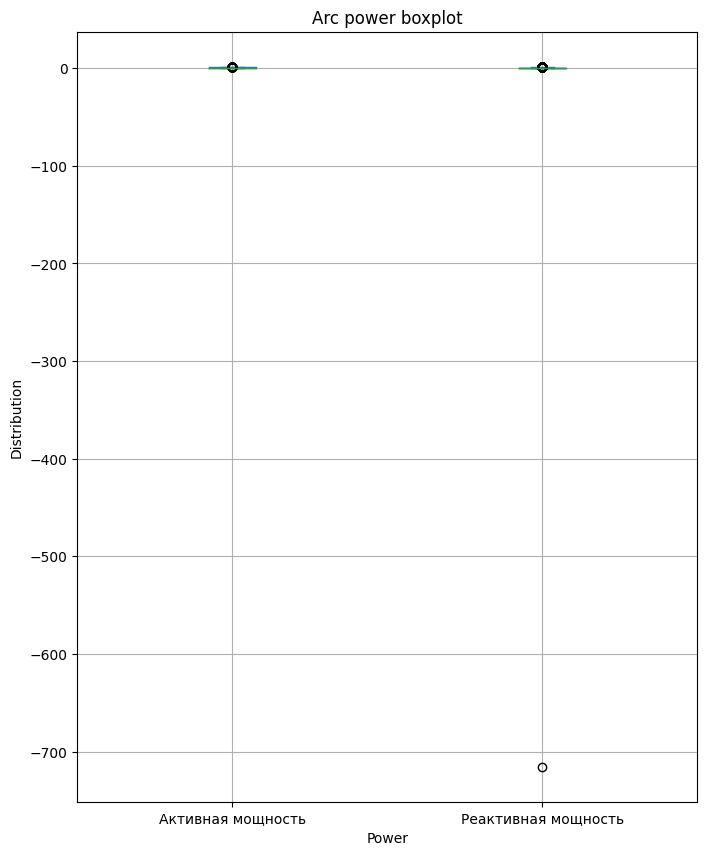

In [200]:
data_graphics(data_arc_new.loc[:, ['Активная мощность', 'Реактивная мощность']], bins=100, title='Arc power', xlabel = 'Power', ylabel = 'Distribution')

In [201]:
data_nan_count(data_arc_new)

Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64


Реактивная мощность для одного из измерений показывает значение > -700. Вероятно, это аномалия. В остальном данные выглядят реалистичными, "хвост" графика активной мощности смещён вправо. Пропущенных значений нет.

#### Bulk volume

In [202]:
data_info(data_bulk_new)

     Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9   
key                                                                           
1       NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN     NaN  \
2       NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN     NaN   
3       NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN     NaN   
4       NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN     NaN   
5       NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN     NaN   

     Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
key                                                        
1        NaN      NaN    206.0      NaN    150.0    154.0  
2        NaN      NaN    206.0      NaN    149.0    154.0  
3        NaN      NaN    205.0      NaN    152.0    153.0  
4        NaN      NaN    207.0      NaN    153.0    154.0  
5        NaN      NaN    203.0      NaN    151.0    152.0  
<class 'pandas.core.frame.

In [203]:
data_nan_count(data_bulk_new)

Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64


Для большинства категорий подавляющее большинство записей пропущено. Эти записи вряд ли нам помогут в задаче. Отбросим их и посмотрим на распределение оставшихся.

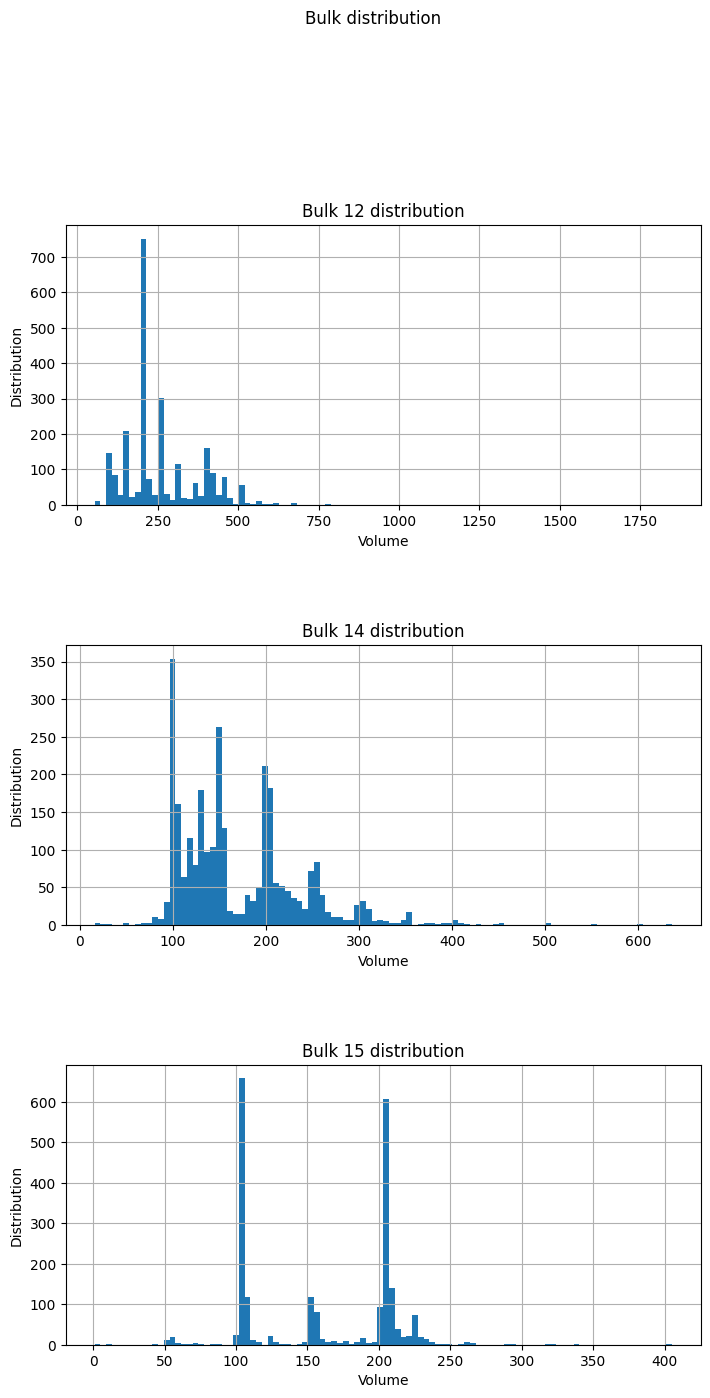

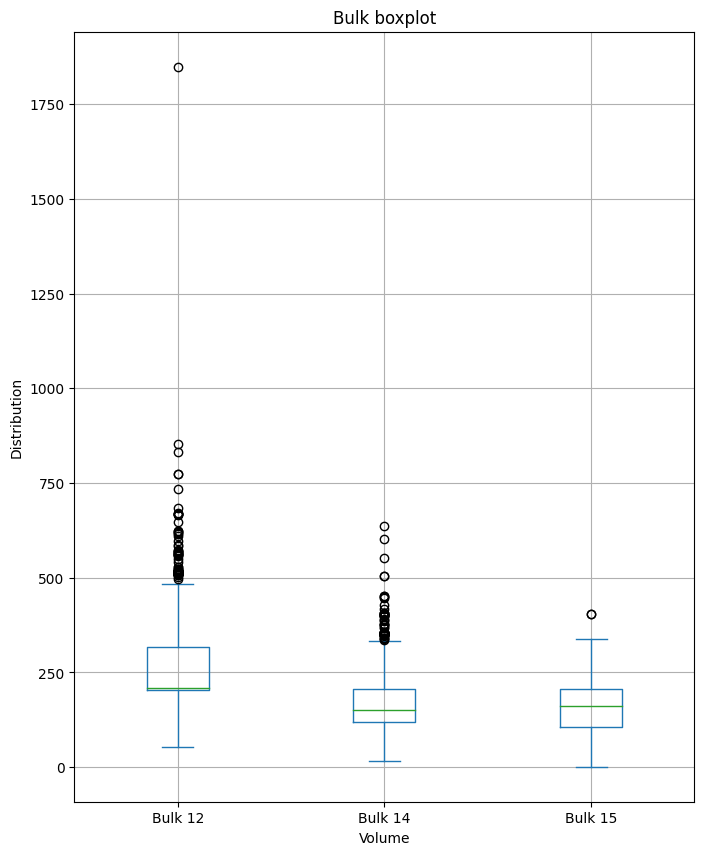

In [204]:
data_graphics(data_bulk_new.loc[:, ['Bulk 12', 'Bulk 14', 'Bulk 15']], 
              title='Bulk', 
              xlabel='Volume', 
              ylabel='Distribution')

Существует несколько аномальных значений.

#### Bulk time

In [205]:
data_bulk_time_new = data_bulk_time_new.apply(pd.to_datetime)

In [206]:
data_info(data_bulk_time_new)

    Bulk 1 Bulk 2 Bulk 3              Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8   
key                                                                        
1      NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT    NaT  \
2      NaT    NaT    NaT 2019-05-03 11:36:50    NaT    NaT    NaT    NaT   
3      NaT    NaT    NaT 2019-05-03 12:32:39    NaT    NaT    NaT    NaT   
4      NaT    NaT    NaT 2019-05-03 12:43:22    NaT    NaT    NaT    NaT   
5      NaT    NaT    NaT 2019-05-03 13:30:47    NaT    NaT    NaT    NaT   

    Bulk 9 Bulk 10 Bulk 11             Bulk 12 Bulk 13             Bulk 14   
key                                                                          
1      NaT     NaT     NaT 2019-05-03 11:24:31     NaT 2019-05-03 11:14:50  \
2      NaT     NaT     NaT 2019-05-03 11:53:30     NaT 2019-05-03 11:48:37   
3      NaT     NaT     NaT 2019-05-03 12:27:13     NaT 2019-05-03 12:21:01   
4      NaT     NaT     NaT 2019-05-03 12:58:00     NaT 2019-05-03 12:51:11   

In [207]:
data_nan_count(data_bulk_time_new)

Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64


В данных аналогичные пропуски, как и в предыдущей таблице. Посмотрим на распределение оставшихся:

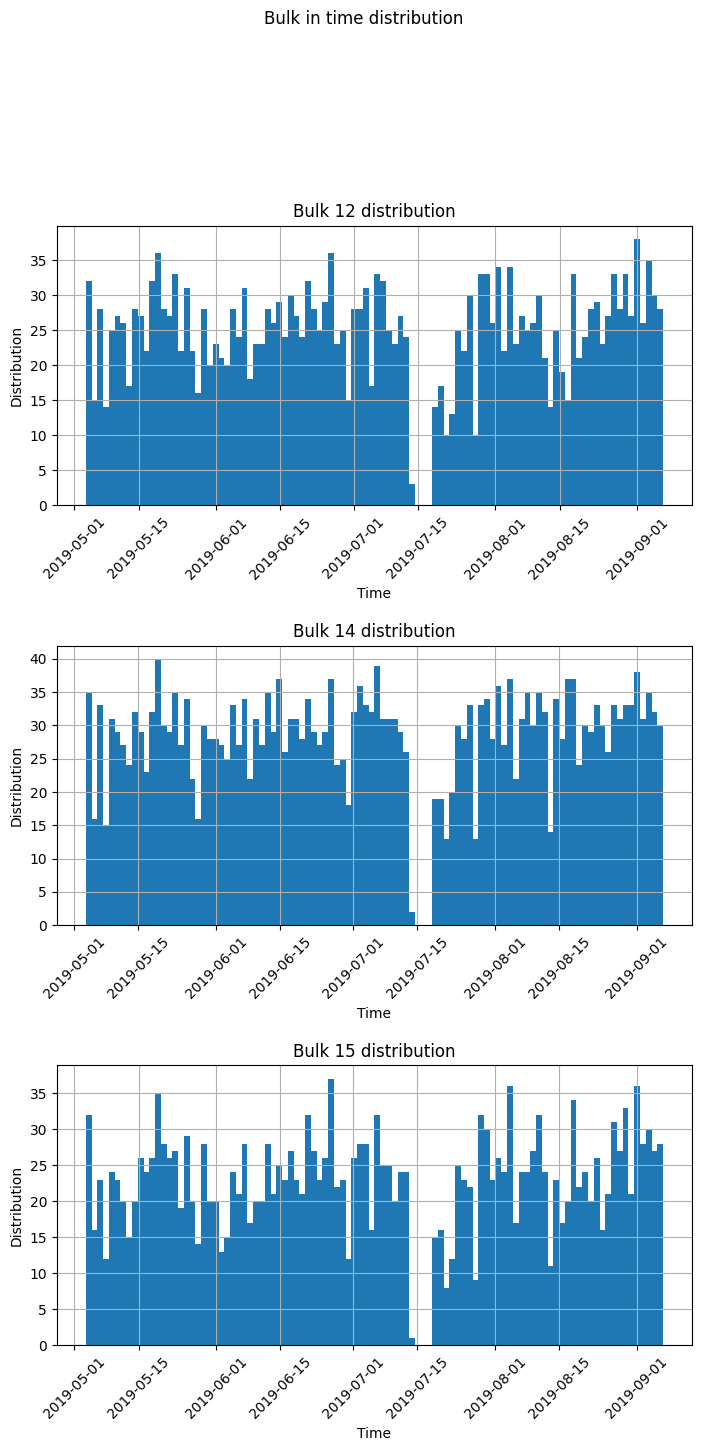

In [208]:
data_graphics(data_bulk_time_new.loc[:, ['Bulk 12', 'Bulk 14', 'Bulk 15']], 
              datetime=True, 
              title='Bulk in time', 
              xlabel='Time',
              rotation=45,
              ylabel = 'Distribution')

Данные времени распределены равномерно, но присутсвует пропуск в данных, когда ничего не было записано, для всех трёх категорий.

#### Gas

In [209]:
data_info(data_gas_new)

         Газ 1
key           
1    29.749986
2    12.555561
3    28.554793
4    18.841219
5     5.413692
<class 'pandas.core.frame.DataFrame'>
Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB
None
             Газ 1
count  3239.000000
mean     11.002062
std       6.220327
min       0.008399
25%       7.043089
50%       9.836267
75%      13.769915
max      77.995040


In [210]:
data_nan_count(data_gas_new)

Газ 1    0.0
dtype: float64


Пропусков нет

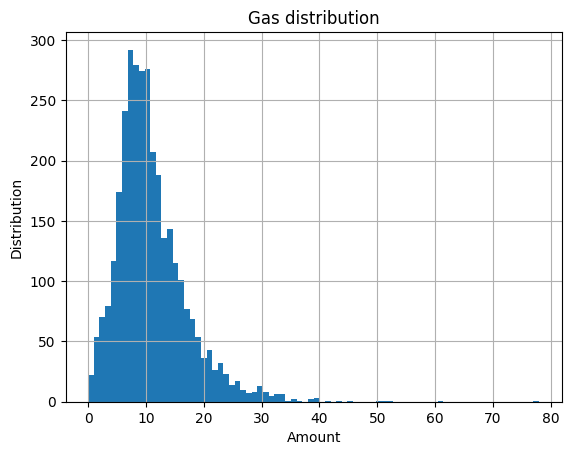

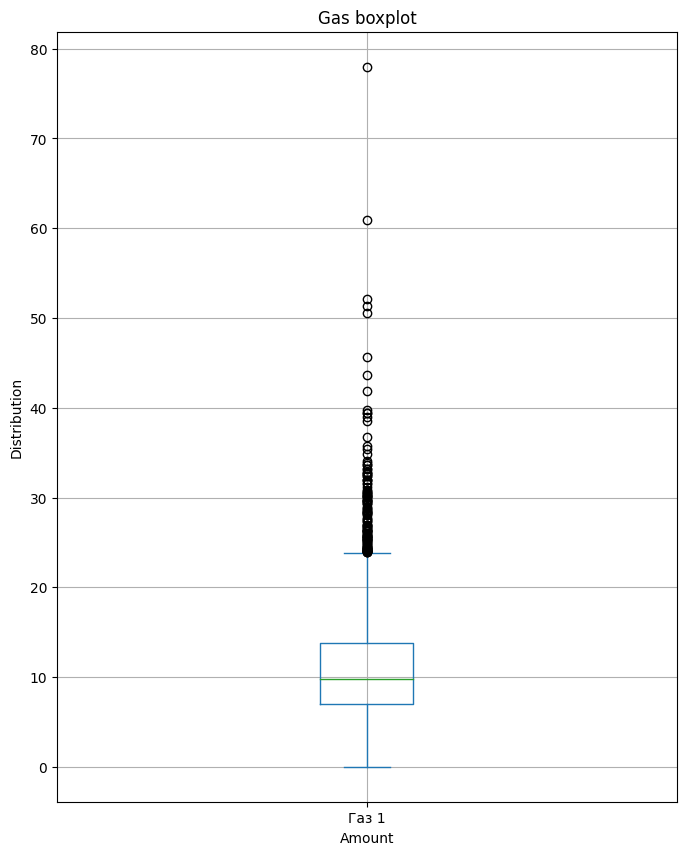

In [211]:
data_graphics(data_gas_new, bins=80, title='Gas', xlabel='Amount', ylabel='Distribution')

В распределении значений газа присутствуют аномалии начиная с 40. В остальном график распределения похож на нормальный.

#### Temp

In [212]:
data_info(data_temp_new)

           Время замера  Температура
key                                 
1   2019-05-03 11:02:04       1571.0
1   2019-05-03 11:07:18       1604.0
1   2019-05-03 11:11:34       1618.0
1   2019-05-03 11:18:04       1601.0
1   2019-05-03 11:25:59       1606.0
<class 'pandas.core.frame.DataFrame'>
Index: 18092 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Время замера  18092 non-null  datetime64[ns]
 1   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 424.0 KB
None
                        Время замера   Температура
count                          18092  14665.000000
mean   2019-07-05 13:36:58.791620608   1590.722741
min              2019-05-03 11:02:04   1191.000000
25%    2019-06-04 00:35:01.249999872   1580.000000
50%              2019-07-03 02:11:48   1590.000000
75%    2019-08-07 23:10:05.249999872   1599.000000
max             

In [213]:
data_temp_new.loc[:,'Время замера'] = data_temp_new.loc[:,'Время замера'].apply(pd.to_datetime)

In [214]:
data_nan_count(data_temp_new)

Время замера    0.000000
Температура     0.189421
dtype: float64


Часть температур не учтена. Возможно, нужно попытаться восстановить эти данные, либо отбросить, если они невосстановимы, так как это наши целевые данные.

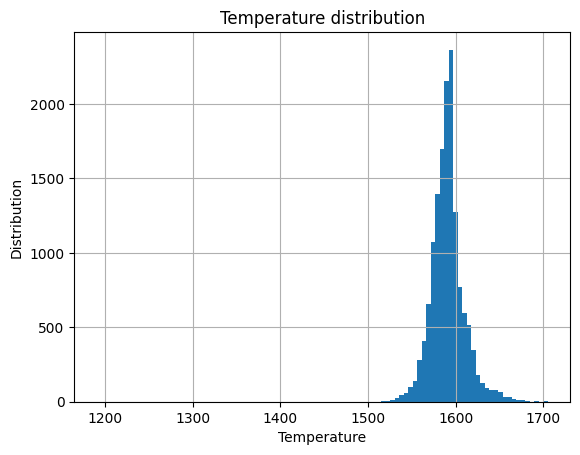

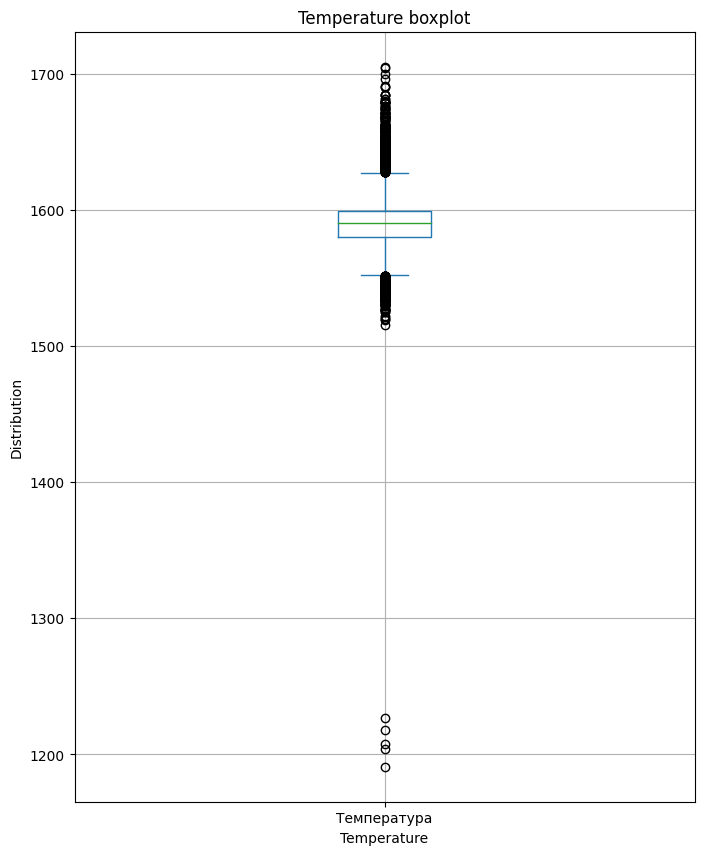

In [215]:
data_graphics(data_temp_new[['Температура']], title='Temperature', xlabel='Temperature', ylabel='Distribution')

Присутствуют аномальные значения температуры в области значений 1200. Для нас это таргетное значение, поэтому имеет смысл обатить внимание на то, почему здесь температура ниже.

#### Wire

In [216]:
data_info(data_wire_new)

        Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8   
key                                                                       
1    60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN  \
2    96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5    89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

     Wire 9  
key          
1       NaN  
2       NaN  
3       NaN  
4       NaN  
5       NaN  
<class 'pandas.core.frame.DataFrame'>
Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3055 non-null   float64
 1   Wire 2  1079 non-null   float64
 2   Wire 3  63 non-null     float64
 3   Wire 4  14 non-null     float64
 4   Wire 5  1 non-null      float64
 5   Wire 6  73 

In [217]:
data_nan_count(data_wire_new)

Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64


Подавляющее количество данных пропущено. Оставим только Wire 1:

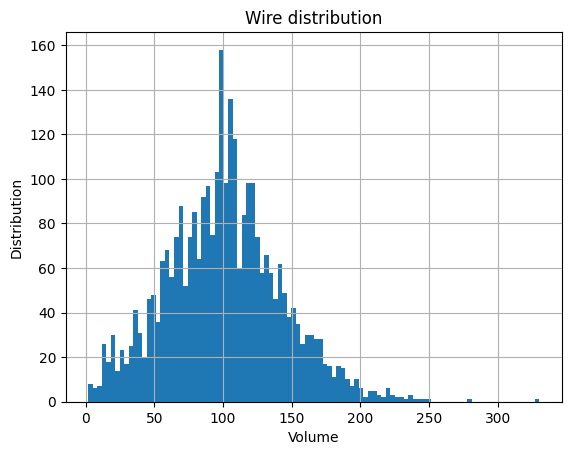

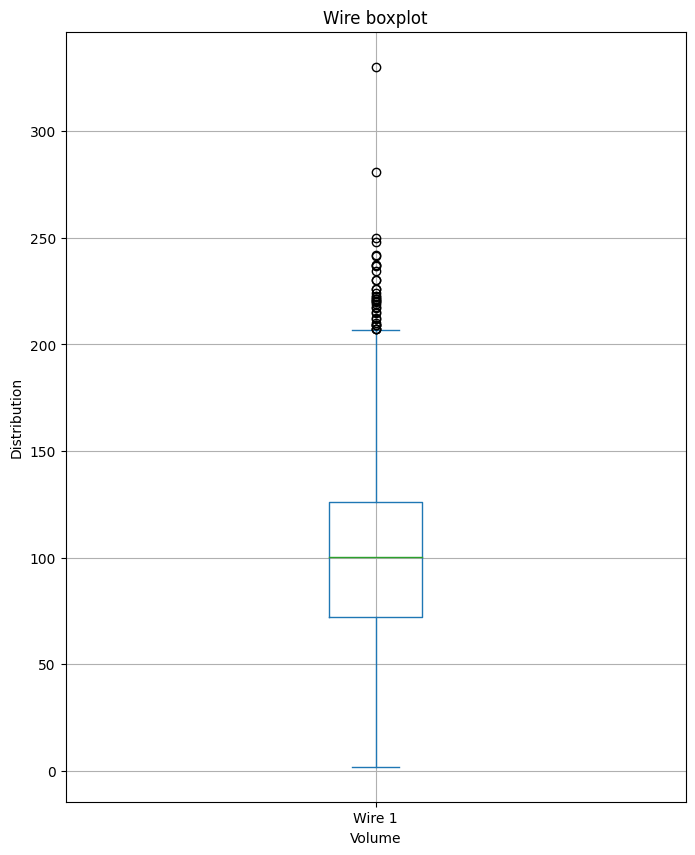

In [218]:
data_graphics(data_wire_new[['Wire 1']], 
              title='Wire', 
              xlabel='Volume', 
              ylabel='Distribution')

Распределение не отличается большим количеством аномалий, распределение данных похоже на нормальное.

### Wire_time

In [219]:
data_wire_time_new = data_wire_time_new.loc[:, 'Wire 1': 'Wire 9'].apply(pd.to_datetime)

In [220]:
data_info(data_wire_time_new)

                 Wire 1              Wire 2 Wire 3 Wire 4 Wire 5 Wire 6   
key                                                                       
1   2019-05-03 11:06:19                 NaT    NaT    NaT    NaT    NaT  \
2   2019-05-03 11:36:50                 NaT    NaT    NaT    NaT    NaT   
3   2019-05-03 12:11:46                 NaT    NaT    NaT    NaT    NaT   
4   2019-05-03 12:43:22                 NaT    NaT    NaT    NaT    NaT   
5   2019-05-03 13:20:44 2019-05-03 13:15:34    NaT    NaT    NaT    NaT   

    Wire 7 Wire 8 Wire 9  
key                       
1      NaT    NaT    NaT  
2      NaT    NaT    NaT  
3      NaT    NaT    NaT  
4      NaT    NaT    NaT  
5      NaT    NaT    NaT  
<class 'pandas.core.frame.DataFrame'>
Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Wire 1  3055 non-null   datetime64[ns]
 1   Wire 2  1079 non-null   datetime64[ns]
 2   Wir

In [221]:
data_nan_count(data_wire_time_new)

Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64


Аналогично оставим только Wire 1:

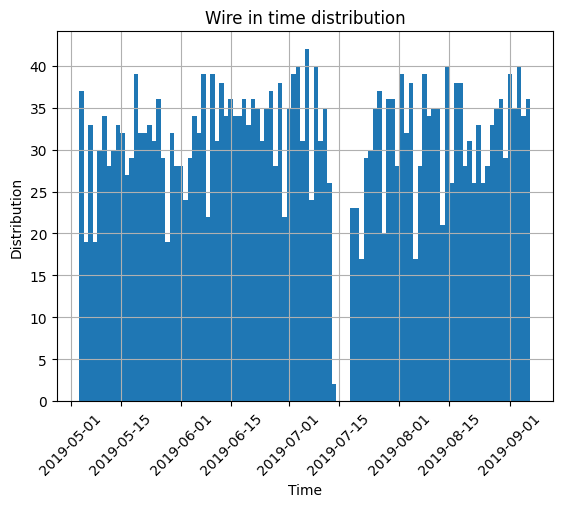

In [222]:
data_graphics(data_wire_time_new[['Wire 1']], datetime=True, 
              xlabel='Time', 
              ylabel = 'Distribution',
              rotation=45,
              title='Wire in time')

В течение всего периода времени распределение wire остаётся практически неизменным, за исключением периода 7 июля. Возможно, в это время производство останавливали.

## План работы

1. Исследование данных: построение графиков, изучение аномалий, построение выводов.
2. Обработка данных: выделение целевого признака из данных, обработка аномалий, пропусков, типов данных, объединение данных в единую таблицу.
3. Подготовка к обучению: выбор признаков, скейлинг, ohe.
4. Обучение: разбиение выборок, выбор модели, подбор гиперпараметров.
5. Тестирование: проверка качества модели на тестовых данных
6. Выводы

## Вывод

В данных присутствует незначительное количество выбросов и аномалий. Часть из аномалий свидетельствуют о неверных данных - такие, как выброс реактивной мощности и температура ниже температуры плавления стали. Эти данные необходимо исключить из датасета. Остальные выбросы, если будем их убирать, удалим только из train выборки.

## Предобработка данных

Таблицей, по которой мы будем присоединять остальные данные, будет таблица с измерениями температуры. Уберём все партии, где отсутствует хотя бы одно измерение температуры:

In [223]:
na_keys = data_temp_new[data_temp_new['Температура'].isna()].index.drop_duplicates()
na_keys

Index([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509,
       ...
       3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241],
      dtype='int64', name='key', length=739)

Также уберём измерения, где температура существенно ниже температуры плавления стали - у нас было несколько значений ниже 1300. Убирать будем всю партию, где есть такие значения.

In [224]:
corrupted_keys = data_temp_new[data_temp_new['Температура'] < 1300].index

In [225]:
object_index = data_temp_new.groupby('key').tail(1).index.tolist()
object_index = [item for item in object_index if (item not in corrupted_keys) & (item not in na_keys)]

data_temp_new = data_temp_new.loc[object_index, :]

Уберём из данных партию, у которой был выброс реактивной мощности:

In [226]:
corrupt_index = data_arc_new[data_arc_new['Реактивная мощность'] < -700].index

In [227]:
data_temp_new = data_temp_new.drop(index = corrupt_index)

In [228]:
data_temp_new

,Время замера,Температура
key,,
1,2019-05-03 11:02:04,1571.0
1,2019-05-03 11:07:18,1604.0
1,2019-05-03 11:11:34,1618.0
1,2019-05-03 11:18:04,1601.0
1,2019-05-03 11:25:59,1606.0
...,...,...
2499,2019-08-10 13:33:21,1569.0
2499,2019-08-10 13:41:34,1604.0
2499,2019-08-10 13:46:28,1593.0


## Extracting features

Преобразуем данные температуры. Для каждого из ключей выделим последнюю температуру, а также время первого и последнего измерения и общую длительность:

In [229]:
data_temp_new

,Время замера,Температура
key,,
1,2019-05-03 11:02:04,1571.0
1,2019-05-03 11:07:18,1604.0
1,2019-05-03 11:11:34,1618.0
1,2019-05-03 11:18:04,1601.0
1,2019-05-03 11:25:59,1606.0
...,...,...
2499,2019-08-10 13:33:21,1569.0
2499,2019-08-10 13:41:34,1604.0
2499,2019-08-10 13:46:28,1593.0


In [230]:
data_final = data_temp_new.groupby('key').tail(1)

In [231]:
data_final = data_final.rename(columns={'Время замера':'end_time', 'Температура':'end_temp'})

In [232]:
data_final['start_time'] = data_temp_new.groupby('key').head(1)['Время замера']

In [233]:
data_final['start_temp'] = data_temp_new.groupby('key').head(1)['Температура']
#data_final = data_final.rename(columns={'Температура':'start_temp'})

In [234]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2472 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   end_time    2472 non-null   datetime64[ns]
 1   end_temp    2472 non-null   float64       
 2   start_time  2472 non-null   datetime64[ns]
 3   start_temp  2472 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.6 KB


#### Features out of bonds

Проверим, чтобы в таблице не было партий, где начало работы реактора/засыпания объёма не ниже начала замера температуры

Измерение arc:

In [235]:
data_final['arc_start_time'] = data_arc_new.groupby('key').head(1)['Начало нагрева дугой']
data_final['arc_end_time'] = data_arc_new.groupby('key').head(1)['Конец нагрева дугой']

data_final[(data_final['arc_start_time'] < data_final['start_time']) | 
           ((data_final['arc_end_time'] > data_final['end_time']))]

,end_time,end_temp,start_time,start_temp,arc_start_time,arc_end_time
key,,,,,,


В Arc все партии ок.

In [236]:
data_final = data_final.drop(['arc_start_time', 'arc_end_time'], axis=1)

Проверим Wire:

In [237]:
data_final['wire_time_max'] = data_wire_time_new.max(axis=1)
data_final['wire_time_min'] = data_wire_time_new.min(axis=1)

data_final[(data_final['wire_time_min'] < data_final['start_time']) | 
           ((data_final['wire_time_max'] > data_final['end_time']))]

,end_time,end_temp,start_time,start_temp,wire_time_max,wire_time_min
key,,,,,,
279,2019-05-14 10:13:01,1603.0,2019-05-14 10:13:01,1603.0,2019-05-14 10:13:37,2019-05-14 10:13:37


В Wire одна партия неверная. Удалим её.

In [238]:
data_final = data_final.drop(index=279)
data_final = data_final.drop(['wire_time_max', 'wire_time_min'], axis=1)
data_final

,end_time,end_temp,start_time,start_temp
key,,,,
1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0
2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0
3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0
4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0
5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0
...,...,...,...,...
2495,2019-08-10 11:50:47,1591.0,2019-08-10 11:27:47,1570.0
2496,2019-08-10 12:25:13,1591.0,2019-08-10 11:56:48,1554.0
2497,2019-08-10 12:53:28,1589.0,2019-08-10 12:37:26,1571.0


Аналогично для Bulk:

In [239]:
data_final['bulk_time_max'] = data_bulk_time_new.max(axis=1)
data_final['bulk_time_min'] = data_bulk_time_new.min(axis=1)

data_final[(data_final['bulk_time_min'] < data_final['start_time']) | 
           ((data_final['bulk_time_max'] > data_final['end_time']))]

,end_time,end_temp,start_time,start_temp,bulk_time_max,bulk_time_min
key,,,,,,


Здесь все партии ок.

In [240]:
data_final = data_final.drop(['bulk_time_max', 'bulk_time_min'], axis=1)
data_final

,end_time,end_temp,start_time,start_temp
key,,,,
1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0
2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0
3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0
4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0
5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0
...,...,...,...,...
2495,2019-08-10 11:50:47,1591.0,2019-08-10 11:27:47,1570.0
2496,2019-08-10 12:25:13,1591.0,2019-08-10 11:56:48,1554.0
2497,2019-08-10 12:53:28,1589.0,2019-08-10 12:37:26,1571.0


Только одна из партий оказалась с ошибочным временем.

#### Train & test division

Теперь разделим данные на train и test. Обработку аномалий будем проводить только для train выборки.

In [241]:
data_final['phase_duration'] = (data_final.end_time - data_final.start_time).dt.total_seconds()

In [242]:
data_final

,end_time,end_temp,start_time,start_temp,phase_duration
key,,,,,
1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0,1714.0
2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0,1265.0
3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0,1753.0
4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0,1220.0
5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0,1536.0
...,...,...,...,...,...
2495,2019-08-10 11:50:47,1591.0,2019-08-10 11:27:47,1570.0,1380.0
2496,2019-08-10 12:25:13,1591.0,2019-08-10 11:56:48,1554.0,1705.0
2497,2019-08-10 12:53:28,1589.0,2019-08-10 12:37:26,1571.0,962.0


Далее разделим выборку на test и train, чтобы не допустить утекания данных в тест при агрегации. Все остальные таблицы мы также будем перед агрегацией разделять на train и test.

In [243]:
data_train, data_test = train_test_split(data_final, test_size=0.25, random_state=110323)

In [244]:
train_indexes = data_train.index
test_indexes = data_test.index

In [245]:
data_train

,end_time,end_temp,start_time,start_temp,phase_duration
key,,,,,
554,2019-05-24 16:13:54,1591.0,2019-05-24 15:36:42,1615.0,2232.0
2254,2019-08-01 15:44:12,1592.0,2019-08-01 15:23:46,1592.0,1226.0
757,2019-06-02 03:09:26,1613.0,2019-06-02 02:38:42,1603.0,1844.0
1041,2019-06-12 13:16:13,1616.0,2019-06-12 12:11:45,1554.0,3868.0
294,2019-05-14 21:27:18,1591.0,2019-05-14 20:56:50,1586.0,1828.0
...,...,...,...,...,...
2464,2019-08-09 06:34:33,1591.0,2019-08-09 05:58:14,1565.0,2179.0
1258,2019-06-20 00:16:58,1611.0,2019-06-19 23:47:49,1600.0,1749.0
542,2019-05-24 01:25:38,1593.0,2019-05-24 01:10:48,1588.0,890.0


#### Arc

Аггрегируем данные arc, посчитаем полную мощность и присоединим к данным температуры:

In [246]:
data_arc_new.groupby('key')

In [247]:
def get_arc_agg(data_arc):
    arc = data_arc.groupby('key')[['Активная мощность', 'Реактивная мощность']].agg(['mean', 'sum'])
    arc.columns = ['_'.join(col) for col in arc.columns.values]
    arc = arc.rename(columns={'Активная мощность_mean':'active_mean', 
                        'Активная мощность_sum':'active_sum',  
                        'Реактивная мощность_mean':'reactive_mean',  
                        'Реактивная мощность_sum':'reactive_sum'})
    arc['full_power'] = np.sqrt(arc['active_sum'] * arc['active_sum'] + arc['reactive_sum'] * arc['reactive_sum'])
    arc = arc.drop(['active_sum', 'reactive_sum'], axis=1)
    return arc

In [248]:
def arc_duration(data_arc):
    
    data_arc['arc_seconds'] = (pd.to_datetime(data_arc.loc[:,'Конец нагрева дугой']) - pd.to_datetime(data_arc.loc[:,'Начало нагрева дугой'])).dt.total_seconds()
    return data_arc.groupby('key')['arc_seconds'].sum()

In [249]:
arc_duration = arc_duration(data_arc_new)

arc_new_train = get_arc_agg(data_arc_new[data_arc_new.index.isin(train_indexes)])
arc_new_train = arc_new_train.join(arc_duration, how='inner')

arc_new_test = get_arc_agg(data_arc_new[data_arc_new.index.isin(test_indexes)])
arc_new_test = arc_new_test.join(arc_duration, how='inner')

data_train = data_train.join(arc_new_train, how='inner')
data_test = data_test.join(arc_new_test, how='inner')

In [250]:
arc_new_train

,active_mean,reactive_mean,full_power,arc_seconds
key,,,,
2,0.534852,0.363339,2.586371,811.0
3,0.812728,0.587491,5.014163,655.0
4,0.676622,0.514248,3.399456,741.0
6,0.681319,0.470328,3.311564,952.0
9,0.704164,0.505473,4.334022,625.0
...,...,...,...,...
2494,0.501592,0.367365,1.865198,550.0
2495,0.792033,0.552734,3.863328,723.0
2496,0.695820,0.478672,5.067396,940.0


#### Gas:

Уберём в train все партии, где gas > 40:

In [251]:
data_gas_new = data_gas_new.rename(columns={'Газ 1': 'gas'})
data_train = data_train.join(data_gas_new[data_gas_new.index.isin(train_indexes)], how='inner')
data_train = data_train.drop(data_train[data_train.gas > 40].index)
data_test = data_test.join(data_gas_new[data_gas_new.index.isin(test_indexes)], how='inner')

In [252]:
data_train

,end_time,end_temp,start_time,start_temp,phase_duration,active_mean,reactive_mean,full_power,arc_seconds,gas
key,,,,,,,,,,
554,2019-05-24 16:13:54,1591.0,2019-05-24 15:36:42,1615.0,2232.0,0.852472,0.633537,5.310549,768.0,8.385707
2254,2019-08-01 15:44:12,1592.0,2019-08-01 15:23:46,1592.0,1226.0,0.502513,0.423439,2.628521,416.0,7.572709
757,2019-06-02 03:09:26,1613.0,2019-06-02 02:38:42,1603.0,1844.0,0.772068,0.594252,5.845687,875.0,10.798049
1041,2019-06-12 13:16:13,1616.0,2019-06-12 12:11:45,1554.0,3868.0,0.615178,0.460200,6.914368,1586.0,10.372674
294,2019-05-14 21:27:18,1591.0,2019-05-14 20:56:50,1586.0,1828.0,0.557521,0.446409,3.571101,668.0,9.888749
...,...,...,...,...,...,...,...,...,...,...
2464,2019-08-09 06:34:33,1591.0,2019-08-09 05:58:14,1565.0,2179.0,0.891786,0.702650,4.541363,892.0,31.621312
1258,2019-06-20 00:16:58,1611.0,2019-06-19 23:47:49,1600.0,1749.0,0.952685,0.734323,6.014231,734.0,13.872219
542,2019-05-24 01:25:38,1593.0,2019-05-24 01:10:48,1588.0,890.0,0.767627,0.579592,1.923724,456.0,7.513538


#### Wire:

Во всех данных для Wire и Bulk заменим пропущенные значения на 0:

In [253]:
data_wire_new = data_wire_new.fillna(0)

Уберём в train данные о Wire 1, где объём больше 250:

In [254]:
wire_clean_indexes = data_wire_new.drop(data_wire_new[data_wire_new['Wire 1'] > 250].index).index
data_train['wire_mean'] = data_wire_new[
    (data_wire_new.index.isin(train_indexes)) & 
    (data_wire_new.index.isin(wire_clean_indexes))].mean(axis=1)
data_test['wire_mean'] = data_wire_new[data_wire_new.index.isin(test_indexes)].mean(axis=1)

In [255]:
def get_wire_time_agg(data_wire_time):
    wire_time = data_wire_time.join(data_final[['start_time', 'phase_duration']])
    for column in wire_time.loc[:,'Wire 1':'Wire 9'].columns:
        wire_time[column] = (wire_time[column] - wire_time.start_time).dt.total_seconds() / wire_time.phase_duration
    wire_time = wire_time.loc[:,'Wire 1': 'Wire 9'].agg('sum', axis=1)
    wire_time = wire_time.rename(columns={'sum':'wire_time_sum'})
    return wire_time

#### Bulk:

Аналогично заполним пропуски 0:

In [256]:
data_bulk_new = data_bulk_new.fillna(0)

Уберём данные из train, где Bulk 12 > 1000

In [257]:
bulk_clean_indexes = data_bulk_new.drop(data_bulk_new[data_bulk_new['Bulk 12'] > 1000].index).index

data_train['bulk_mean'] = data_bulk_new[
    (data_bulk_new.index.isin(train_indexes)) & 
    (data_bulk_new.index.isin(bulk_clean_indexes))].mean(axis=1)

data_test['bulk_mean'] = data_bulk_new[data_bulk_new.index.isin(test_indexes)].mean(axis=1)

In [258]:
data_bulk_new.index.isin(train_indexes)

array([False,  True,  True, ..., False, False, False])

In [259]:
def get_bulk_time_agg(data_bulk_time):
    
    bulk_time = data_bulk_time.join(data_final[['start_time', 'phase_duration']])
    for column in bulk_time.loc[:,'Bulk 1':'Bulk 14'].columns:
        bulk_time[column] = (bulk_time[column] - bulk_time.start_time).dt.total_seconds() / bulk_time.phase_duration
    bulk_time = bulk_time.loc[:,'Bulk 1':'Bulk 14'].agg('sum', axis=1)
    bulk_time = bulk_time.rename(columns={'sum':'bulk_time_sum'})
    return bulk_time

In [260]:
#data_train = data_train.join(get_bulk_time_agg(data_bulk_time_new[data_bulk_time_new.index.isin(train_indexes)]), how='inner')
#data_test = data_test.join(get_bulk_time_agg(data_bulk_time_new[data_bulk_time_new.index.isin(test_indexes)]), how='inner')

In [261]:
data_train.head()

,end_time,end_temp,start_time,start_temp,phase_duration,active_mean,reactive_mean,full_power,arc_seconds,gas,wire_mean,bulk_mean
key,,,,,,,,,,,,
554,2019-05-24 16:13:54,1591.0,2019-05-24 15:36:42,1615.0,2232.0,0.852472,0.633537,5.310549,768.0,8.385707,16.468401,46.133333
2254,2019-08-01 15:44:12,1592.0,2019-08-01 15:23:46,1592.0,1226.0,0.502513,0.423439,2.628521,416.0,7.572709,12.294764,28.000000
757,2019-06-02 03:09:26,1613.0,2019-06-02 02:38:42,1603.0,1844.0,0.772068,0.594252,5.845687,875.0,10.798049,16.151199,39.866667
1041,2019-06-12 13:16:13,1616.0,2019-06-12 12:11:45,1554.0,3868.0,0.615178,0.460200,6.914368,1586.0,10.372674,19.276747,59.800000
294,2019-05-14 21:27:18,1591.0,2019-05-14 20:56:50,1586.0,1828.0,0.557521,0.446409,3.571101,668.0,9.888749,11.041333,33.400000


#### Multicollinearity test

Для проверки на мультиколлинеарность построим heatmap:

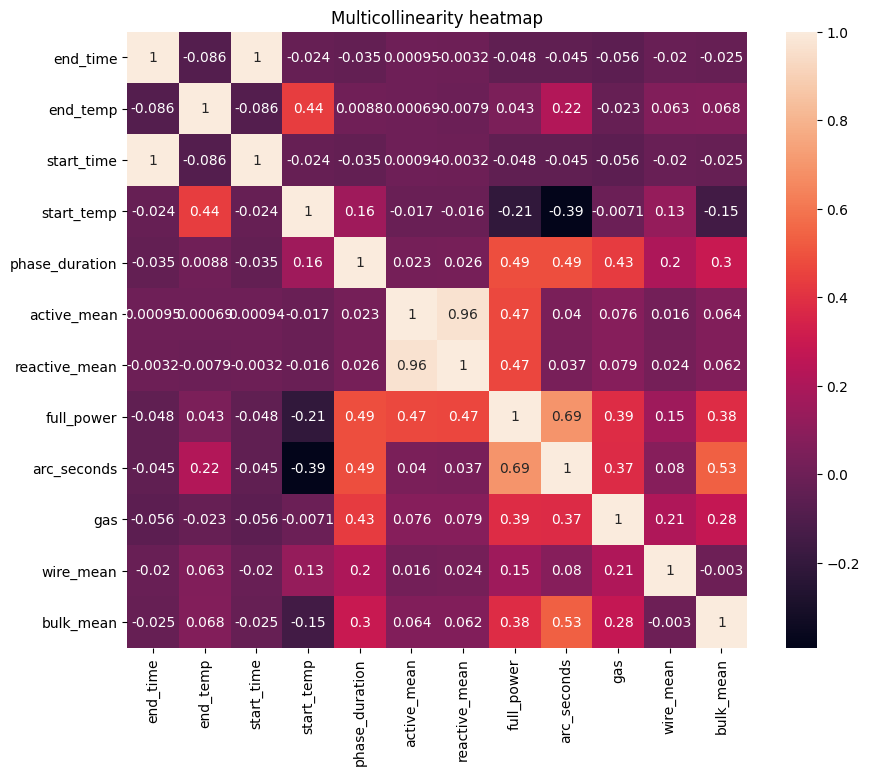

In [262]:
corr = data_train.corr()
fig, ax = plt.subplots(figsize=(10,8)) 
sn.heatmap(corr, annot=True)
plt.title('Multicollinearity heatmap')
plt.show()

Сильно коррелируют друг с другом значения active и reactive (выше 0.9). Уберём reactive из трейн и тест датасета:

In [263]:
data_train = data_train.drop(['reactive_mean'], axis=1)
data_test = data_test.drop(['reactive_mean'], axis=1)

In [264]:
data_train = data_train.drop(['end_time','start_time'], axis=1)
data_test = data_test.drop(['end_time','start_time'], axis=1)

Снова построим heatmap:

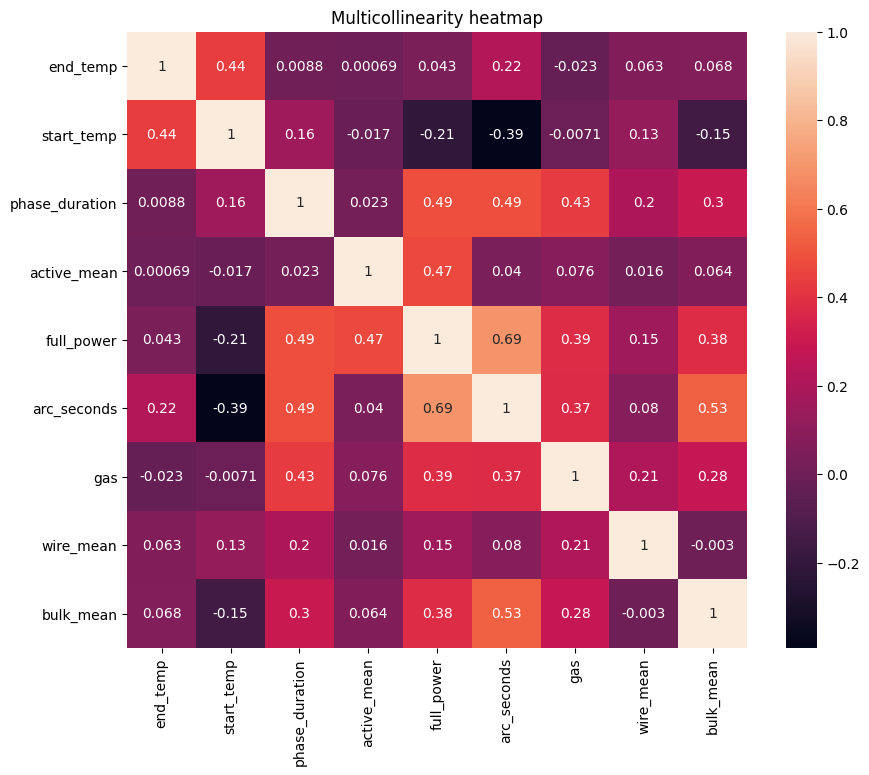

In [265]:
corr = data_train.corr()
fig, ax = plt.subplots(figsize=(10,8)) 
sn.heatmap(corr, annot=True)
plt.title('Multicollinearity heatmap')
plt.show()

In [266]:
def remove_inf(data):
    wire_inf_index = data[data.wire_time_sum == np.inf].index
    #data.loc[wire_inf_index, 'wire_time_mean'] = np.nan
    data.loc[wire_inf_index, 'wire_time_sum'] = np.nan
    
    bulk_inf_index = data[data.bulk_time_mean == np.inf].index
    data.loc[bulk_inf_index, 'bulk_time_mean'] = np.nan
    data.loc[bulk_inf_index, 'bulk_time_sum'] = np.nan
    
    return data

In [267]:
#data_train = remove_inf(data_train)
#data_test = remove_inf(data_test)

In [268]:
data_train.describe()

,end_temp,start_temp,phase_duration,active_mean,full_power,arc_seconds,gas,wire_mean,bulk_mean
count,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1767.000000,1792.000000
mean,1595.580401,1589.073633,2247.658906,0.664863,3.790910,794.106118,10.995553,13.975276,40.397507
std,16.195043,25.051647,1199.502500,0.127239,1.450340,323.420369,5.885151,7.077914,18.997768
min,1543.000000,1520.000000,370.000000,0.317607,0.427675,57.000000,0.008399,0.213200,1.266667
25%,1588.000000,1572.000000,1549.000000,0.577773,2.769449,573.000000,7.102961,9.898373,28.600000
50%,1593.000000,1587.000000,2016.000000,0.656374,3.666741,775.000000,9.893686,13.031199,40.633333
75%,1599.000000,1605.000000,2717.500000,0.742241,4.688605,978.000000,13.809662,16.900231,53.200000
max,1700.000000,1679.000000,19409.000000,1.243889,10.912061,2755.000000,39.728826,63.197518,104.600000


In [269]:
data_train

,end_temp,start_temp,phase_duration,active_mean,full_power,arc_seconds,gas,wire_mean,bulk_mean
key,,,,,,,,,
554,1591.0,1615.0,2232.0,0.852472,5.310549,768.0,8.385707,16.468401,46.133333
2254,1592.0,1592.0,1226.0,0.502513,2.628521,416.0,7.572709,12.294764,28.000000
757,1613.0,1603.0,1844.0,0.772068,5.845687,875.0,10.798049,16.151199,39.866667
1041,1616.0,1554.0,3868.0,0.615178,6.914368,1586.0,10.372674,19.276747,59.800000
294,1591.0,1586.0,1828.0,0.557521,3.571101,668.0,9.888749,11.041333,33.400000
...,...,...,...,...,...,...,...,...,...
2464,1591.0,1565.0,2179.0,0.891786,4.541363,892.0,31.621312,27.034684,45.733333
1258,1611.0,1600.0,1749.0,0.952685,6.014231,734.0,13.872219,12.662000,44.800000
542,1593.0,1588.0,890.0,0.767627,1.923724,456.0,7.513538,14.804401,49.000000


## Training

Разделим данные на features и target:

In [270]:
features_train = data_train.drop('end_temp', axis=1)
features_test = data_test.drop('end_temp', axis=1)

target_train = data_train.end_temp
target_test = data_test.end_temp

In [271]:
best_score = 100
best_model = RandomForestRegressor()

#### Random Forest

Проверим случайный лес:

In [272]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                 ('scaler', StandardScaler()),
                 ('model', RandomForestRegressor())])
param_grid = {   
    'model__random_state':[110923],
    'model__max_depth':[3, 5, 7],
    'model__min_samples_split':[2, 3, 5],
    'model__n_estimators':[100, 150, 200, 300]
}

In [273]:
%%time
rf_search = GridSearchCV(pipe, scoring = 'neg_mean_absolute_error', param_grid=param_grid, cv=3)
rf_search.fit(features_train, target_train)

CPU times: total: 1min 26s
Wall time: 1min 26s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             param_grid={'model__max_depth': [3, 5, 7],
                         'model__min_samples_split': [2, 3, 5],
                         'model__n_estimators': [100, 150, 200, 300],
                         'model__random_state': [110923]},
             scoring='neg_mean_absolute_error')

In [274]:
rf_search.best_params_

{'model__max_depth': 7,
 'model__min_samples_split': 3,
 'model__n_estimators': 300,
 'model__random_state': 110923}

In [275]:
rf_best_score = rf_search.best_score_

In [276]:
rf_best_score

-6.9574525324508905

In [277]:
rf_best_model = rf_search.best_estimator_

In [278]:
if np.abs(rf_best_score) < best_score:
    best_score = np.abs(rf_best_score)
    best_model = rf_best_model

In [279]:
rf_best_model = rf_search.best_estimator_

#### Gradient boosting

Проверим градиентный бустинг:

In [280]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                 ('scaler', StandardScaler()),
                 ('model', LGBMRegressor())])
param_grid = {   
    'model__random_state':[110923],
    'model__max_depth':[-1, 8, 16, 32, 48],
    'model__num_leaves':[4, 8, 16, 24, 31, 45, 64],
    'model__n_estimators':[50, 100, 150, 200]
}

In [281]:
%%time
gb_search = GridSearchCV(pipe, scoring = 'neg_mean_absolute_error', cv=3, param_grid=param_grid)
gb_search.fit(features_train, target_train)

CPU times: total: 4min 11s
Wall time: 23 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model', LGBMRegressor())]),
             param_grid={'model__max_depth': [-1, 8, 16, 32, 48],
                         'model__n_estimators': [50, 100, 150, 200],
                         'model__num_leaves': [4, 8, 16, 24, 31, 45, 64],
                         'model__random_state': [110923]},
             scoring='neg_mean_absolute_error')

In [282]:
gb_best_score = gb_search.best_score_

In [283]:
gb_best_model = gb_search.best_estimator_

In [284]:
if np.abs(gb_best_score) < best_score:
    best_score = np.abs(gb_best_score)
    best_model = gb_best_model

#### LinearRegression

Проверим линейную регрессию:

In [285]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                 ('scaler', StandardScaler()),
                 ('model', LinearRegression())])

In [286]:
lr_best_score = cross_val_score(pipe, features_train, target_train, cv=3, scoring='neg_mean_absolute_error').mean()

In [287]:
lr_best_score

-7.771463819056493

In [288]:
if np.abs(lr_best_score) < best_score:
    best_score = np.abs(lr_best_score)
    best_model = gb_best_model

## Testing

Лучший скор на трейне:

In [289]:
best_score

6.769962631752969

Лучшая модель:

In [290]:
best_model

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', LGBMRegressor(num_leaves=8, random_state=110923))])

Посмотрим на feature importances для лучшей модели:

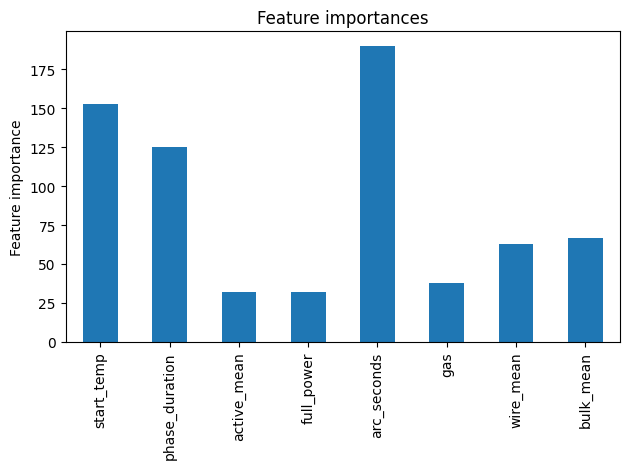

In [291]:
feature_importances = pd.Series(best_model[2].feature_importances_, index=features_train.columns)

fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Feature importance")
fig.tight_layout()

Самые важные features для модели - начальная температура, длительность нагрева и длительность работы электродов.

Тест лучшей модели:

In [292]:
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                 ('scaler', StandardScaler()),
                 ('model', best_model)])

In [293]:
pipe.fit(features_train, target_train)
predictions = pipe.predict(features_test)
mean_absolute_error(predictions, target_test)

6.561559378022495

## Отчёт по проекту

1. Выполнены все пункты плана, за исключением не понадобившихся деталей: ohe (в данных не было и не добавилось новых категориальных признаков). Разбиение выборок было проведено на этапе предобработки данных.
2. Ключевая трудность - выход на целевые метрики, осуществившийся с помощью добавления в тренировочный датасет информации о начальной температуре и времени работы электродов.
3. Ключевые шаги:
- выбрать, какие данные использовать в финальной модели, и какие выделить из имеющихся датасетов. 
- определить, как обработать входные данне - что считать выбросами и ошибками, а что оставить.
- определить модели для этапа валидации и гиперпараметры для них.
- протестировать лучшую модель на валидации.
4. Итоговая модель - LGBMRegressor(num_leaves=8, random_state=110923)). На тестовых данных модель показала качество MAE 6.62. Интересно то, что на кросс-валидации метрика модели хуже.

Список признаков: 
1. start_temp - этот признак выделялся из таблицы data_temp_new. Из таблицы были удалены все данные, где температура указана сильно ниже температуры плавления стали. Также удалены все партии, где есть хотя бы один пропуск в измерении температуры. В дальнейшем из остальных таблиц брались только партии, соотвествующие правильным ключам температуры.
2. phase_duration - это признак, указывающий длину этапа нагрева от первого до последнего измерения температуры партии. 
3. active_mean - среднее значение активной мощности партии. Все значения попали в датасет. 
4. full_power - значение полной мощности партии. Из датасета была удалена партия в сыбросом реактивной мощности.
5. arc_seconds - общее время работы электродов. Для попадания в датасет учитывалось, что начало и конец работы электродов должны быть в пределах интервала первого и последнего замера значения температуры.
6. gas - объём газа, использовавшегося для каждой партии.
7. wire_mean - среднее значение wire, использовавшееся в каждой партии. В данных о wire большое количество пропусков, все они были заменены на 0 на этапе предобработки. Также проверялось, чтобы не было партий, где время добавления выходит за границы диапазона начала и конца измерения температуры.
8. bulk_mean - среднее значение bulk, использовавшееся в каждой партии. Пропуски также были заменены на 0. Также проверялось попадание в диапазон времени измерения температуры

Гиперпараметры модели LGBMRegressor:
- num_leaves = 8
- max_depth = -1 (default)
- n_estimators = 100 (default)
- random_state = 110923

Для улучшения эффективности модели, помимо более тщательного подбора гиперпараметров, можно добавить информацию о химическом составе стали, её качестве, дополнительную классификацию. Также добавить классификацию электродов, если она может различаться. Также можно классифицировать тип колебаний температуры от среднего для каждой партии - например, в пределах нормы, за пределами нормы, выброс.